In [1]:
import struct
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from utils.colmap_utils import (read_cameras_binary,
                                read_points3D_binary, 
                                read_images_binary, 
                                create_transforms_json)
from utils.plot_utils import visualize_point_cloud
from utils.matrix import quaternion_to_rotation_vectorized
from glob import glob
import cv2
from concurrent.futures import ThreadPoolExecutor

from scipy.spatial import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [39]:
cameras_file = "data/sparse/0/cameras.bin"
cameras_data = read_cameras_binary(cameras_file)
width, height = cameras_data[1]["width"], cameras_data[1]["height"]
"""
K = [fx 0 cx
     0 fy cy
     0 0 1]
"""
intrinsics = np.array(cameras_data[1]["params"])
K = np.array([[intrinsics[0], 0, intrinsics[1]],
                             [0, intrinsics[0], intrinsics[2]],
                             [0, 0, 1]])

In [91]:
images_file = "data/sparse/0/images.bin"
images_data = read_images_binary(images_file)

qvecs = np.array([v['qvec'] for v in images_data.values()])
tvecs = np.array([v['tvec'] for v in images_data.values()])

rotation = quaternion_to_rotation_vectorized(qvecs)
"""
E = [R t
    0 1]
"""
extrinsics = np.zeros((len(images_data), 4, 4))
extrinsics[:, :3, :3] = rotation
extrinsics[:, :3, 3] = tvecs
extrinsics[:, 3, 3] = 1
# WORLD to camera instead of camera to world
extrinsics = np.linalg.inv(extrinsics)
frame_names = [v['name'] for v in images_data.values()]

E = {k: extrinsics[i] for i, k in enumerate(frame_names)}

In [92]:
# points3D_file = "data/dense/dense_points3D.bin"
# not noticing significant difference between sparse / dense (from original gaussian-splatting repository)
points3D_file = "data/sparse/0/points3D.bin"
points3D_data = read_points3D_binary(points3D_file)

points = np.array([v["xyz"] for v in points3D_data.values()])
colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])

In [116]:
def project_points(points, e, K):
    # homogenous coordinates
    points_h = np.hstack([points, np.ones((len(points), 1))])
    # First apply extrinsics (4x4 @ 4xN)
    transformed_points = (e @ points_h.T)
    # Then apply intrinsics (3x3 @ 3xN), but we need to remove the homogeneous coordinate first
    transformed_points = transformed_points[:3, :]
    # Now project with intrinsics
    projected_points = (K @ transformed_points).T
    # Divide by z to get image coordinates
    projected_points = projected_points[:, :2] / projected_points[:, 2:3]

    return projected_points

def select_points_within_bounds(projected_points, width, height, colors=None):
    bound_indices = np.all(projected_points >= 0, axis=1) & np.all(projected_points < [width, height], axis=1)
    bound_points = projected_points[bound_indices]
    if colors is not None:
        bound_colors = colors[bound_indices]
        return bound_points, bound_colors
    return bound_points, None

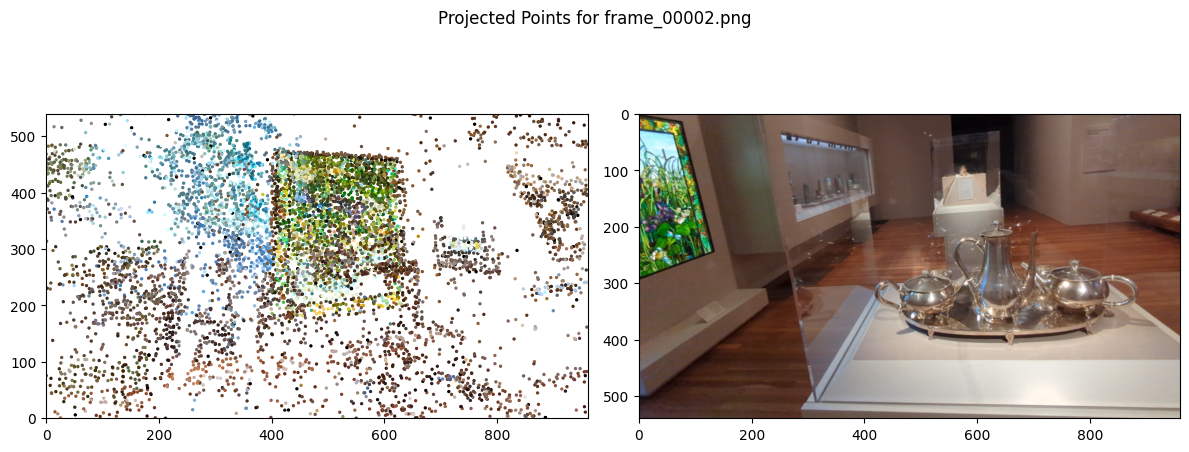

In [136]:
# select points within image bounds

i = 60
e = E[frame_names[i]]

projected_points = project_points(points, e, K)

bound_points, bound_colors = select_points_within_bounds(projected_points, width, height, colors)

img = plt.imread(f"data/images/{frame_names[i]}")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Set an explicit figure size

# Set aspect ratio to 'equal' for both plots
axs[0].scatter(bound_points[:, 0], bound_points[:, 1], c=bound_colors, s=2)
axs[0].set_aspect('equal')
axs[0].set_xlim(0, width)
axs[0].set_ylim(0, height)  # Flip Y-axis to match image coordinates

axs[1].imshow(img)
axs[1].set_aspect('equal')

plt.suptitle(f"Projected Points for {frame_names[0]}")
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [148]:
# print(f"Loaded {len(points)} points")

# visualize_point_cloud(points, colors)

In [149]:
class GaussianSplatting:
    def __init__(self, images_path='data/images', points_path='data/sparse/0/points3D.bin'):
        self.M_points = self.get_sfm_points(points_path)
        self.images, self.height, self.width = self.get_images(images_path)
        self.points = None
        self.sigmas = None
        self.colors = None 
        self.alphas = None

    def get_images(self, images_path):
        images_data = sorted(glob(images_path + '/*.png'))
        with ThreadPoolExecutor() as executor: # faster loading
            images = list(executor.map(cv2.imread, images_data))
        height, width, _ = images[0].shape
        return images, height, width

    def get_sfm_points(self, points_path):
        """
        𝑀 ← SfM Points ⊲ Positions
        """
        points3D_data = read_points3D_binary(points_path)
        points = np.array([v["xyz"] for v in points3D_data.values()])
        colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])
        return points, colors
    
    def init_attributes(self):
        """
        𝑆,𝐶, 𝐴 ← InitAttributes() ⊲ Covariances, Colors, Opacities

        https://medium.com/@yianyao1994/gaussian-splatting-part-2-representation-and-initialization-c0a036adf16e
        
        Center: Set to the point cloud locations from SfM.
        Scaling factor: Initialized as isotropic, using the mean distance to the 3-nearest neighbors.
        Rotation: No initial rotation is applied.
        Opacity: Set to 0.1.
        Spherical Harmonics (SH): Inherited from the color information in the point cloud.

        """
        # 3D covariance matrix Σ
        pass

    def init_gaussian_covariance(self, points):
        """
        Explanation
        Sec 4: 
            Directly optimizing covariance matrix Σ can lead to non positive non semi-definite covariance matrices.
            Instead, we factorize Σ = 𝑅𝑆𝑆^𝑇𝑅^𝑇 [7dof], allowing anisotropic covariance and valid covariance matrices.
            For independent optimization, we store S: 3D vector for scaling and quaternion q (normalize to get valid unit quaternion)

            Convert these splats to pixel space
                W viewing transformation or extrinsics
                J Jacobian projective transformation or intrinsics
                Σ' = JW Σ W^TJ^T

        Initialization
        Sec 5.1
            "We estimate the initial covariance matrix as an isotropic Gaussian 
            with axes equal to the mean of the distance to the closest three points."

        Gradient Computation
        Appendix A
            dΣ' / ds = dΣ'/dΣ * dΣ / ds
            dΣ' / dq = dΣ'/dΣ * dΣ / dq

        Simplify Σ' = JW Σ W^TJ^T using U=JW and Σ' being (symmetric) upper left 2x2
        Σ' = U Σ U^T
        """
        # non gradient implementation for now
        # Have to revist complexity of KDTree
        kdtree = KDTree(points)
        distances, _ = kdtree.query(points, k=4)  # k=4 includes the point itself
        
        nearest_distances = distances[:, 1:4]
        mean_distances = nearest_distances.mean(axis=1)

        unit_q = np.array([1, 0, 0, 0])
        # ensure q is normalized
        q = np.repeat(unit_q[np.newaxis, :], len(points), axis=0) # (N, 4)
        r = quaternion_to_rotation_vectorized(q) # (N, 3, 3)

        # when initalizing, we sqrt since we will do (S @ ST) first
        s = np.sqrt(mean_distances[:, None, None]) * np.eye(3) # (N, 3, 3)

        # we do (S @ ST) first because it's a symmetric matrix
        # then we apply Rotation
        sigma = np.einsum('nij,nkj,nml,nlk->nim', s, s, r, r)
        return sigma



In [143]:
model = GaussianSplatting()
sigmas = model.init_gaussian_covariance(points)

In [144]:
# project with camera intrinsics and extrinsics

model.images

[array([[[248, 187, 102],
         [237, 176,  91],
         [232, 165,  76],
         ...,
         [ 10,   7,   8],
         [ 11,   8,   9],
         [ 10,   7,   8]],
 
        [[255, 197, 109],
         [241, 181,  93],
         [233, 167,  76],
         ...,
         [  9,   6,   7],
         [  7,   4,   5],
         [  9,   6,   7]],
 
        [[253, 192,  98],
         [239, 178,  84],
         [228, 160,  66],
         ...,
         [  8,   5,   6],
         [  7,   4,   5],
         [  8,   5,   6]],
 
        ...,
 
        [[ 42,  47,  77],
         [ 43,  48,  78],
         [ 40,  45,  75],
         ...,
         [ 22,  58, 114],
         [ 25,  58, 114],
         [ 24,  57, 113]],
 
        [[ 41,  46,  76],
         [ 42,  47,  77],
         [ 45,  50,  80],
         ...,
         [ 27,  62, 118],
         [ 25,  58, 114],
         [ 26,  59, 115]],
 
        [[ 41,  46,  76],
         [ 43,  48,  78],
         [ 43,  48,  78],
         ...,
         [ 28,  61, 117],
  

In [96]:
def create_ellipsoids_as_one_mesh(points, sigmas, colors, sphere_resolution=5):
    base_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0, resolution=sphere_resolution)
    base_sphere.compute_vertex_normals()
    
    all_vertices = []
    all_triangles = []
    all_colors = []

    base_vertices = np.asarray(base_sphere.vertices)
    base_triangles = np.asarray(base_sphere.triangles)

    vertex_count = 0
    
    for center, sigma, color in zip(points, sigmas, colors):
        # scale and translate vertices
        scales = np.diagonal(sigma)
        transformed_vertices = base_vertices * scales + center

        # store the transformed vertices
        all_vertices.append(transformed_vertices)
        # store color for each vertex
        all_colors.append(np.tile(color, (len(base_vertices), 1)))
        
        # shift the triangle indices by the current total count of vertices
        shifted_triangles = base_triangles + vertex_count
        all_triangles.append(shifted_triangles)

        vertex_count += len(base_vertices)
    
    # Combine everything
    all_vertices = np.vstack(all_vertices)
    all_triangles = np.vstack(all_triangles)
    all_colors = np.vstack(all_colors)

    big_mesh = o3d.geometry.TriangleMesh()
    big_mesh.vertices = o3d.utility.Vector3dVector(all_vertices)
    big_mesh.triangles = o3d.utility.Vector3iVector(all_triangles)
    big_mesh.vertex_colors = o3d.utility.Vector3dVector(all_colors)
    big_mesh.compute_vertex_normals()

    return big_mesh

viz_sigmas = sigmas / 4
big_mesh = create_ellipsoids_as_one_mesh(points, viz_sigmas, colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

